<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>


# Setup
Let's begin by installing and importing the modules we'll need.

In [3]:
#!pip install -q --upgrade pyro-ppl torch
import pyro
import torch
import pyro.distributions as dist
import matplotlib.pyplot as plt
#assert pyro.__version__.startswith('1.8.1')

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>


# Icecream Shop

In this self study session, you will be modeling the sales in an ice cream shop. Below you will find an initial specification, and in the following sections you should elaborate on this initial specificaton.

The basis for our model is that 
* We **record the ice-cream sales and the average temperature of the day** (using a temperature sensor).

* We know **temperature affects the sales** of ice-creams.

* We want to **precisely model** how temperature affects ice-cream sales.

<center>
<img src="https://github.com/PGM-Lab/probai-2021-pyro/raw/main/Day1/Figures/Ice-cream_shop_-_Florida.jpg" alt="Drawing" width=300 >
</center>

Note that the model given below is a extension of the temperature model that we explored during the last lecture.


<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>


## Model specification

* We have **observations** from temperature and sales:
>- The relation between the daily temperature $t_i$ and the measured temperature $s_{t,i}$ will be modeled with a Normal distribution as in the last lecture. 
* Daily sales $s_i$ are modeled with a <a href="https://en.wikipedia.org/wiki/Poisson_distribution">Poisson distribution</a>, which expresses the probability of a given number of sales per day based on a so-called rate parameter (the mean and variance of the Poisson distribution is also equal to the rate parameeter):
>- We assume that the rate of the Poisson distribution **linearly depends of the real temperature**.

The figure below gives a formal description of the model:
<center>
<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/Ice-Cream-Shop-Model.png?raw=1" alt="Drawing" width=700>
</center>



### Pyro specification of the ice-cream model

In [4]:
#The observatons   
obs = {'sensor': torch.tensor([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1]),
       'sales': torch.tensor([46., 47., 49., 44., 50., 54., 51., 52., 49., 53.])}

def model(obs):
    mean_temp = pyro.sample('mean_temp', dist.Normal(15.0, 2.0))
    alpha = pyro.sample('alpha', dist.Normal(0.0, 100.0))
    beta = pyro.sample('beta', dist.Normal(0.0, 100.0))

    with pyro.plate('N='+str(obs['sensor'].shape[0]), obs['sensor'].shape[0]):
        temp = pyro.sample('temp', dist.Normal(mean_temp, 2.0))
        sensor = pyro.sample('sensor', dist.Normal(temp, 1.0), obs=obs['sensor'])
        rate = torch.max(torch.tensor(0.001), alpha + beta*temp)
        sales = pyro.sample('sales', dist.Poisson(rate), obs=obs['sales'])

#Visualize the model
#pyro.render_model(model, model_args=(obs, ))

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>


### Auxiliary function

In SVI, the goal is to maximize the evidence lower bound (ELBO), which serves as the loss function. The ELBO is a lower bound on the log marginal likelihood of the model, and maximizing it corresponds to minimizing the Kullback-Leibler (KL) divergence between the true posterior distribution and the approximating distribution (in this case, the AutoNormal guide).

In [5]:
from torch.distributions import constraints
from pyro.optim import SGD
from pyro.infer import Trace_ELBO
import matplotlib.pyplot as plt
from pyro.contrib.autoguide import AutoNormal


def svi(model, obs, guide=None, num_steps = 500, plot = False, verbose=False, lr=0.01):
    
    torch.manual_seed(999)

    pyro.clear_param_store()
    
    if guide is None:
        guide = AutoNormal(model)
    
    svi = pyro.infer.SVI(model=model,
                         guide=guide,
                         optim=SGD({"lr": lr, "momentum":0.1}),
                         loss=Trace_ELBO())

    losses, a,b  = [], [], []
    
    for t in range(num_steps):
        losses.append(svi.step(obs))
        if t%100==0:
            print('Step: '+str(t)+'. Loss: ' +str(losses[-1]))
            

    if (plot):
        plt.plot(losses)
        plt.title("ELBO")
        plt.xlabel("step")
        plt.ylabel("loss");
        plt.show()
        
    if verbose:
        print("Inference results:")
        for name, value in pyro.get_param_store().items():
            print(name, pyro.param(name))

## Learning and inference

Let's take our model out for a test run

In [6]:
#Run inference
svi(model, obs, num_steps = 3000, lr = 0.001)

#Print results    
print("Posterior temperature mean")
print(dist.Normal(pyro.param("AutoNormal.locs.mean_temp").item(), pyro.param("AutoNormal.scales.mean_temp").item()))
print("")
print("Posterior alpha")
print(dist.Normal(pyro.param("AutoNormal.locs.alpha").item(), pyro.param("AutoNormal.scales.alpha").item()))
print("")
print("Posterior beta")
print(dist.Normal(pyro.param("AutoNormal.locs.beta").item(), pyro.param("AutoNormal.scales.beta").item()))


Step: 0. Loss: 6918.239556312561
Step: 100. Loss: 1706.8236722946167
Step: 200. Loss: 1406.9380152225494
Step: 300. Loss: 1167.6915589571
Step: 400. Loss: 969.2325354814529
Step: 500. Loss: 804.8420561552048
Step: 600. Loss: 669.4958707690239
Step: 700. Loss: 560.7486241459846
Step: 800. Loss: 474.48593854904175
Step: 900. Loss: 392.1056379079819
Step: 1000. Loss: 340.65715539455414
Step: 1100. Loss: 280.3072943687439
Step: 1200. Loss: 257.1041859984398
Step: 1300. Loss: 207.26763075590134
Step: 1400. Loss: 189.91815966367722
Step: 1500. Loss: 164.52883219718933
Step: 1600. Loss: 154.52774381637573
Step: 1700. Loss: 126.25959062576294
Step: 1800. Loss: 117.71674519777298
Step: 1900. Loss: 112.76154679059982
Step: 2000. Loss: 100.08532202243805
Step: 2100. Loss: 98.10363984107971
Step: 2200. Loss: 92.16423934698105
Step: 2300. Loss: 80.70324516296387
Step: 2400. Loss: 79.52285540103912
Step: 2500. Loss: 71.62698209285736
Step: 2600. Loss: 76.57986891269684
Step: 2700. Loss: 68.352946341

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>


### <span style="color:red">Exercise 1: Analyze the model above </span> 
* Consider the model specification together with the posterior distributions over the model parameters. Do the these distributions appear reasonabale to you considering the model and the data that you have supplied?

**Mean temperature**: N(17.97, 0.53)

The prior mean was N(15, 2). And the new observations by the sensor lead us to think that the temperature has risen, since the mean of the values for the sensor is 19.75. Therefore it's natural for the model to update the distribution of the temperature by rising it slightly.

**Posterior alpha**: N(39.84, 1.13)

Measures baseline of sales when the temperature is zero. In my opinion this coefficient is a bit too high, since when the temperatures are cold the icecream shop still expects to do particularly well in sales.

**Posterior beta**: N(0.53, 0.12)

It does make sense for posterior beta to be positive, since there is a positive correlation between the temperature and the sales of the icecream shop.

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>


### <span style="color:red">Exercise 2: Introduce Humidity in the Icecream shop model </span> 

In this exercise you should extend the model above to also account for the daily humidity $h_i$:
* Assume we also have a bunch of daily humidity sensor measurements $s_{h,i}$.
* Assume the **sales are also linearly influenced by the humidity**.

Extend the model above in order to integrate these new pieces of information.

The figure below gives a formal description of the model:
<center>
<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/Ice-Cream-Shop-Model-Humidity.png?raw=1" alt="Drawing" width=1000>
</center>




In [7]:
#The observatons   
obs = {'sensor': torch.tensor([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1]),
       'sales': torch.tensor([46., 47., 49., 44., 50., 54., 51., 52., 49., 53.]),
       'sensor_humidity': torch.tensor([82.8, 87.6, 69.1, 74.2, 80.3, 94.2, 91.2, 92.2, 99.1, 93.2])}


def model(obs):
    mean_temp = pyro.sample('mean_temp', dist.Normal(15.0, 2.0))
    ## Introduce a random variable "mean_humidity"
    mean_humidity = pyro.sample('mean_humidity', dist.Normal(80.0, 5.0))

    alpha = pyro.sample('alpha', dist.Normal(0.0, 100.0))
    beta = pyro.sample('beta', dist.Normal(0.0, 100.0))
    
    ## Introduce a coefficient for the humidity "gamma"
    gamma = pyro.sample('gamma', dist.Normal(0.0, 100.0))

    with pyro.plate('N='+str(obs['sensor'].shape[0]), obs['sensor'].shape[0]):
        temp = pyro.sample('temp', dist.Normal(mean_temp, 2.0))
        sensor = pyro.sample('sensor', dist.Normal(temp, 1.0), obs=obs['sensor'])
        #Add the 'humidity' variable and the 'sensor_humidity' variable
        humidity = pyro.sample('humidity', dist.Normal(mean_humidity, 2.0))
        sensor_humidity = pyro.sample('sensor_humidity', dist.Normal(humidity, 1.0), obs = obs['sensor_humidity'])
        #Add the linear dependency for the rate with respect to temp and humidity (keep torch.max to avoid numerical stability issues)
        rate = torch.max(torch.tensor(0.001), alpha + beta * temp + gamma * humidity)
        sales = pyro.sample('sales', dist.Poisson(rate), obs=obs['sales'])

#Visualize the model
#pyro.render_model(model, model_args=(obs, ))

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>

Again, we rely on the **(variational) inference engine** to get the results.

In [8]:
#Run inference
svi(model, obs, num_steps=3000, lr=0.001)

#Print results    
print("Posterior temperature mean")
print(dist.Normal(pyro.param("AutoNormal.locs.mean_temp").item(), pyro.param("AutoNormal.scales.mean_temp").item()))
print("")
print("Posterior Humidity Mean")
print(dist.Normal(pyro.param("AutoNormal.locs.mean_humidity").item(), pyro.param("AutoNormal.scales.mean_humidity").item()))
print("")
print("Posterior alpha")
print(dist.Normal(pyro.param("AutoNormal.locs.alpha").item(), pyro.param("AutoNormal.scales.alpha").item()))
print("")
print("Posterior beta")
print(dist.Normal(pyro.param("AutoNormal.locs.beta").item(), pyro.param("AutoNormal.scales.beta").item()))
print("")
print("Posterior Gamma")
print(dist.Normal(pyro.param("AutoNormal.locs.gamma").item(), pyro.param("AutoNormal.scales.gamma").item()))


Step: 0. Loss: 43415.62390649319
Step: 100. Loss: 32385.001614689827
Step: 200. Loss: 26350.055327892303
Step: 300. Loss: 21488.486026763916
Step: 400. Loss: 17607.421809911728
Step: 500. Loss: 14453.095253229141
Step: 600. Loss: 11926.557882666588
Step: 700. Loss: 9850.370415866375
Step: 800. Loss: 8091.017718791962
Step: 900. Loss: 6682.581264793873
Step: 1000. Loss: 5537.713573336601
Step: 1100. Loss: 4582.031024694443
Step: 1200. Loss: 3812.805470943451
Step: 1300. Loss: 3114.997103571892
Step: 1400. Loss: 2678.0932369828224
Step: 1500. Loss: 2197.6451115608215
Step: 1600. Loss: 1855.675103187561
Step: 1700. Loss: 1547.3147820830345
Step: 1800. Loss: 1284.761683166027
Step: 1900. Loss: 1079.213412642479
Step: 2000. Loss: 926.1470230221748
Step: 2100. Loss: 821.330871462822
Step: 2200. Loss: 681.4236485958099
Step: 2300. Loss: 590.1313971877098
Step: 2400. Loss: 532.2305933237076
Step: 2500. Loss: 449.0510798096657
Step: 2600. Loss: 413.5097807645798
Step: 2700. Loss: 381.9172815084

Results somewhat make sense, the less humid it is, the more icecream will be sold

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>

# 5.  **Temporal Models**

If we expect that there might a temporal dependency between the variables, we can capture this in the model specification.

Let us assume that there is a **temporal dependency** between the variables.

* E.g. the current real temperature must be similar to the real temperature in the previous time step.

This temporal dependency can be modeled using a **for-loop** in Pyro as illustrated in the graphical representation.


<img src="https://github.com/PGM-Lab/probai-2021-pyro/raw/main/Day1/Figures/tempmodel-temporal-III.png" alt="Drawing" style="width: 350px;" >

Observe how this temporal model shares commonalities with the temporal models that we discussed a couple of lectures a go. 

In [9]:
#The observatons   
obs = {'sensor': torch.tensor([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1])}

def model(obs):
    mean_temp = pyro.sample('mean_temp', dist.Normal(15.0, 2.0))
    for i in range(obs['sensor'].shape[0]):
        if i==0:
            temp = pyro.sample(f'temp_{i}', dist.Normal(mean_temp, 2.0))
        else:
            temp = pyro.sample(f'temp_{i}', dist.Normal(prev_temp, 2.0))
        sensor = pyro.sample(f'sensor_{i}', dist.Normal(temp, 1.0), obs=obs['sensor'][i])
        prev_temp = temp

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>

Again, we rely on the **(variational) inference engine** to get the results.

In [10]:
import time
        
#Run inference
svi(model, obs)

smooth_temp=[]
for i in range(obs['sensor'].shape[0]):
    smooth_temp.append(pyro.param(f"AutoNormal.locs.temp_{i}").item())

print('Finished')

Step: 0. Loss: 2015.5972965955734
Step: 100. Loss: 267.1860017180443
Step: 200. Loss: 58.00642055273056
Step: 300. Loss: 28.139065146446228
Step: 400. Loss: 22.716069102287292
Finished


We can now plot the **observed measurements** of the temperature **against** the inferred **real temperature**.

* By querying the **local hidden** we can **smooth** the temperature.

* The **recovered temperature** is much less noisy than the measured one. 

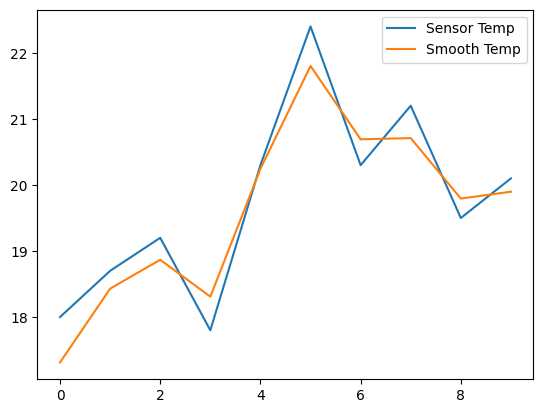

In [12]:
plt.plot([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1], label='Sensor Temp')
plt.plot(smooth_temp, label='Smooth Temp')
plt.legend()

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>

### <span style="color:red">Exercise 3:  Temporal Extension of the Iceacream shop model </span> 

Assume that:
* temperature depends of the **temperature in the previous day**.
* humidity depends of the **humidity in the previous day**.
* sales depends on the **current temperature and humidity**.

Use the following **graphical representation for reference**.

<img src="https://github.com/PGM-Lab/probai-2021-pyro/raw/main/Day1/Figures/icecream-model-temporal.png" alt="Drawing" width=800 >

Note that the plate representation has to be coded in Pyro using a **``for-loop``**.

In [15]:
#The observatons   
obs = {'sensor': torch.tensor([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1]),
       'sales': torch.tensor([46., 47., 49., 44., 50., 54., 51., 52., 49., 53.]),
       'sensor_humidity': torch.tensor([82.8, 87.6, 69.1, 74.2, 80.3, 94.2, 91.2, 92.2, 99.1, 93.2])}



def model(obs):
    mean_temp = pyro.sample('mean_temp', dist.Normal(15.0, 2.0))
    ## Introduce a random variable "mean_humidity"
    mean_humidity = pyro.sample('mean_humidity', dist.Normal(80.0, 5.0))


    alpha = pyro.sample('alpha', dist.Normal(0.0, 100.0))
    beta = pyro.sample('beta', dist.Normal(0.0, 100.0))
    ## Introduce a coefficient for the humidity "gamma"
    gamma = pyro.sample('gamma', dist.Normal(0.0, 100.0))

    for i in range(obs['sensor'].shape[0]):
        if i==0:
            temp = pyro.sample(f'temp_{i}', dist.Normal(mean_temp, 2.0))
            #Introduce the 'humidity' variable at time 0.
            humidity = pyro.sample(f'humidity_{i}', dist.Normal(mean_humidity, 2.0))
        else:
            temp = pyro.sample(f'temp_{i}', dist.Normal(prev_temp, 2.0))
            #Introduce the f'humidity_{i}' variable defining the transition
            humidity = pyro.sample(f'humidity_{i}', dist.Normal(prev_humidity, 2.0))
            
        sensor = pyro.sample(f'sensor_{i}', dist.Normal(temp, 1.0), obs=obs['sensor'][i])
        #Introduce the f'sensor_humidity_{i}' variable. 
        sensor_humidity = pyro.sample(f'sensor_humidity_{i}', dist.Normal(humidity, 1.0), obs = obs['sensor_humidity'][i])
        
        #Add the linear dependency for the rate with respect to temp and humidity (keep torch.max to avoid numerical stability issues)
        rate = torch.max(torch.tensor(0.001), alpha + beta * temp + gamma * humidity)
        sales = pyro.sample(f'sales_{i}', dist.Poisson(rate), obs=obs['sales'][i])

        prev_temp = temp
        #Keep humidity for the next time step. 
        prev_humidity = humidity

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>


Again we need a guide for performing inference (you need not worry about the details of this part)

In [16]:
import time
        
#Run inference
svi(model, obs, num_steps=1000)

smooth_temp=[]
smooth_humidity=[]

for i in range(obs['sensor'].shape[0]):
    smooth_temp.append(pyro.param(f'AutoNormal.locs.temp_{i}').item())
    smooth_humidity.append(pyro.param(f'AutoNormal.locs.humidity_{i}').item())

print('Finished')

Step: 0. Loss: 43401.776953458786
Step: 100. Loss: 12716.639549076557
Step: 200. Loss: 6327.650604993105
Step: 300. Loss: 5364.758997529745
Step: 400. Loss: 5177.399602115154
Step: 500. Loss: 5098.891563475132
Step: 600. Loss: 5042.138681471348
Step: 700. Loss: 5036.21246778965
Step: 800. Loss: 6624.527812302113
Step: 900. Loss: 5180.510523587465
Finished


<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>

Again, we can plot the observered measurements of the temperature against the **inferred real temperature** by our model. The **recovered temperature** is much less noisy than the real one.

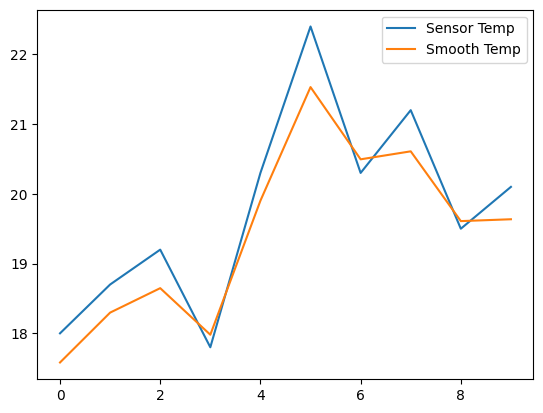

In [17]:
plt.plot([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1], label='Sensor Temp')
plt.plot(smooth_temp, label='Smooth Temp')
plt.legend()

We can also plot the observered measurements of the humidity against the **inferred real humidity** by our model. The **recovered humidity** is much less noisy than the real one.

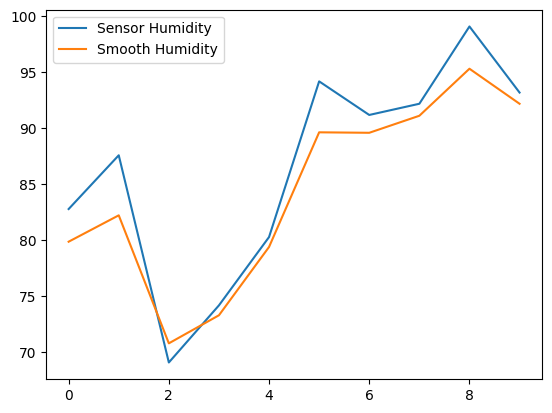

In [18]:
humidity = torch.tensor([82.8, 87.6, 69.1, 74.2, 80.3, 94.2, 91.2, 92.2, 99.1, 93.2])
plt.plot(humidity.detach().numpy(), label='Sensor Humidity')
plt.plot(smooth_humidity, label='Smooth Humidity')
plt.legend()

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>
